In [46]:
import sagemaker
from sklearn.model_selection import train_test_split
import boto3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings('ignore')

# Create a client
sm_boto3 = boto3.client("sagemaker")
# Create a session
sess = sagemaker.Session()
# Set region by default
region = sess.boto_session.region_name
# Mi bucket name
bucket = 'bucketsagemaker-ia' # created S3 bucket name
print("Using bucket " + bucket)


Using bucket bucketsagemaker-ia


In [31]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

Exploratory analysis and clean data:

In [32]:
# Exploratory analysis train set:
print(u'- Number of records: {}'.format(train.shape[0]))
print(u'- Number of variables: {}'.format(train.shape[1]))
print(u'- Names of independent variables: {}'.format(list(train.columns.difference(['PesoTotalTARGET']))),'\n\n')
train.head(4)

- Number of records: 29731
- Number of variables: 14
- Names of independent variables: ['AeropuertoLlegada', 'AeropuertoSalida', 'AnioSalida', 'DiaSalida', 'FechaSalida', 'FuelTotal', 'Maletas', 'MesSalida', 'NumeroVuelo', 'Pasajeros', 'PesoMaletas', 'Ruta', 'TiempoVuelo'] 




,FechaSalida,AnioSalida,MesSalida,DiaSalida,NumeroVuelo,AeropuertoSalida,AeropuertoLlegada,Ruta,TiempoVuelo,FuelTotal,Pasajeros,Maletas,PesoMaletas,PesoTotalTARGET
0,01/10/2016,2016,10,1,1145,MAN,SXF,MAN-SXF,91,3660,175,61,440,64016
1,01/10/2016,2016,10,1,1160,CTA,FCO,CTA-FCO,68,3280,182,27,350,66138
2,01/10/2016,2016,10,1,1183,LGW,SNN,LGW-SNN,64,2720,127,(null),(null),58447
3,01/10/2016,2016,10,1,1220,ATH,CHQ,ATH-CHQ,35,1682,163,12,150,60587


In [33]:
train.dtypes

FechaSalida          object
AnioSalida            int64
MesSalida             int64
DiaSalida             int64
NumeroVuelo           int64
AeropuertoSalida     object
AeropuertoLlegada    object
Ruta                 object
TiempoVuelo           int64
FuelTotal             int64
Pasajeros            object
Maletas              object
PesoMaletas          object
PesoTotalTARGET      object
dtype: object

In [34]:
# Transform some of the variables that appear as object into int64

# First, I use the 'coerce' function to convert values that appear as '(null)' into NaN
train['Pasajeros'] = pd.to_numeric(train['Pasajeros'], errors='coerce')
train['Maletas'] = pd.to_numeric(train['Maletas'], errors='coerce')
train['PesoMaletas'] = pd.to_numeric(train['PesoMaletas'], errors='coerce')
train['PesoTotalTARGET'] = pd.to_numeric(train['PesoTotalTARGET'], errors='coerce')

train['Pasajeros'] = train['Pasajeros'].astype('Int64')
train['Maletas'] = train['Maletas'].astype('Int64')
train['PesoMaletas'] = train['PesoMaletas'].astype('Int64')
train['PesoTotalTARGET'] = train['PesoTotalTARGET'].astype('Int64')

# I transform the variable "NumeroVuelo" to object
train['NumeroVuelo'] = train['NumeroVuelo'].astype('object')

# I repeat the same process for the test set:
test['Pasajeros'] = pd.to_numeric(test['Pasajeros'], errors='coerce')
test['Maletas'] = pd.to_numeric(test['Maletas'], errors='coerce')
test['PesoMaletas'] = pd.to_numeric(test['PesoMaletas'], errors='coerce')

test['Pasajeros'] = test['Pasajeros'].astype('Int64')
test['Maletas'] = test['Maletas'].astype('Int64')
test['PesoMaletas'] = test['PesoMaletas'].astype('Int64')

test['NumeroVuelo'] = test['NumeroVuelo'].astype('object')


In [35]:
# Analysis of missing values:
print(pd.DataFrame({'Number of NaN values': train.isna().sum(), 
                    'Proportion of NaN (%)': (train.isna().sum() / train.shape[0]) * 100})
      .sort_values(by='Number of NaN values', ascending=False), '\n\n')

print('Total number of missing values in the dataframe: ', train.isnull().sum().sum())
print('Percentage of missing values in the dataframe: ', train.isnull().mean().mean())
print('Number of rows with missing values: ', train.isnull().any(axis=1).sum())
print('Percentage of rows with any missing value in the dataset: ', (train.shape[0]) / train.isnull().any(axis=1).sum())
print('Number of duplicate records: ', train.duplicated().sum())

                   Number of NaN values  Proportion of NaN (%)
PesoMaletas                        2478               8.334735
Maletas                            2284               7.682217
PesoTotalTARGET                     433               1.456392
Pasajeros                            95               0.319532
FechaSalida                           0               0.000000
AnioSalida                            0               0.000000
AeropuertoSalida                      0               0.000000
NumeroVuelo                           0               0.000000
DiaSalida                             0               0.000000
MesSalida                             0               0.000000
FuelTotal                             0               0.000000
TiempoVuelo                           0               0.000000
Ruta                                  0               0.000000
AeropuertoLlegada                     0               0.000000 


Total number of missing values in the dataframe:  52

In [36]:
# Basic descriptive train set
train.describe()

,AnioSalida,MesSalida,DiaSalida,TiempoVuelo,FuelTotal,Pasajeros,Maletas,PesoMaletas,PesoTotalTARGET
count,29731.0,29731.0,29731.000000,29731.000000,29731.000000,29636.0,27447.0,27253.0,29298.0
mean,2016.0,10.0,7.987723,110.069221,4782.483536,167.268626,45.417022,573.618464,65031.246638
std,0.0,0.0,4.313351,52.457470,2069.865460,20.177527,32.797217,376.524581,3339.385728
min,2016.0,10.0,1.000000,2.000000,600.000000,4.0,1.0,3.0,42991.0
25%,2016.0,10.0,4.000000,73.000000,3210.000000,163.0,23.0,300.0,63127.0
50%,2016.0,10.0,8.000000,105.000000,4530.000000,173.0,39.0,490.0,65122.0
75%,2016.0,10.0,12.000000,140.000000,6010.000000,179.0,62.0,780.0,67154.0
max,2016.0,10.0,15.000000,1504.000000,17890.000000,189.0,1180.0,10530.0,74283.0


In [37]:
# Basic descriptive test set
test.describe()

,AnioSalida,MesSalida,DiaSalida,TiempoVuelo,FuelTotal,Pasajeros,Maletas,PesoMaletas
count,1916.0,1916.0,1916.0,1916.000000,1916.000000,1910.0,1776.0,1769.0
mean,2016.0,10.0,15.0,112.551670,4880.154489,172.176963,53.591779,658.972301
std,0.0,0.0,0.0,59.131221,2161.970258,13.176526,50.598686,454.532352
min,2016.0,10.0,15.0,22.000000,1090.000000,67.0,1.0,6.0
25%,2016.0,10.0,15.0,74.000000,3280.000000,168.0,27.0,340.0
50%,2016.0,10.0,15.0,107.000000,4600.000000,175.0,46.0,570.0
75%,2016.0,10.0,15.0,141.000000,6107.750000,181.0,73.0,910.0
max,2016.0,10.0,15.0,1440.000000,14550.000000,189.0,1180.0,9100.0


In [38]:
# Considering that the year and month are always the same, I drop the columns 'FechaSalida', 'AnioSalida', and 'MesSalida' for both train and test, keeping only the 'Día' column.

train = train.drop(['AnioSalida', 'FechaSalida', 'MesSalida'], axis=1) 
test = test.drop(['AnioSalida', 'FechaSalida', 'MesSalida'], axis=1)

In [39]:
# I remove the records with missing values from the training set (10% of the records in the training set)
train = train.dropna()

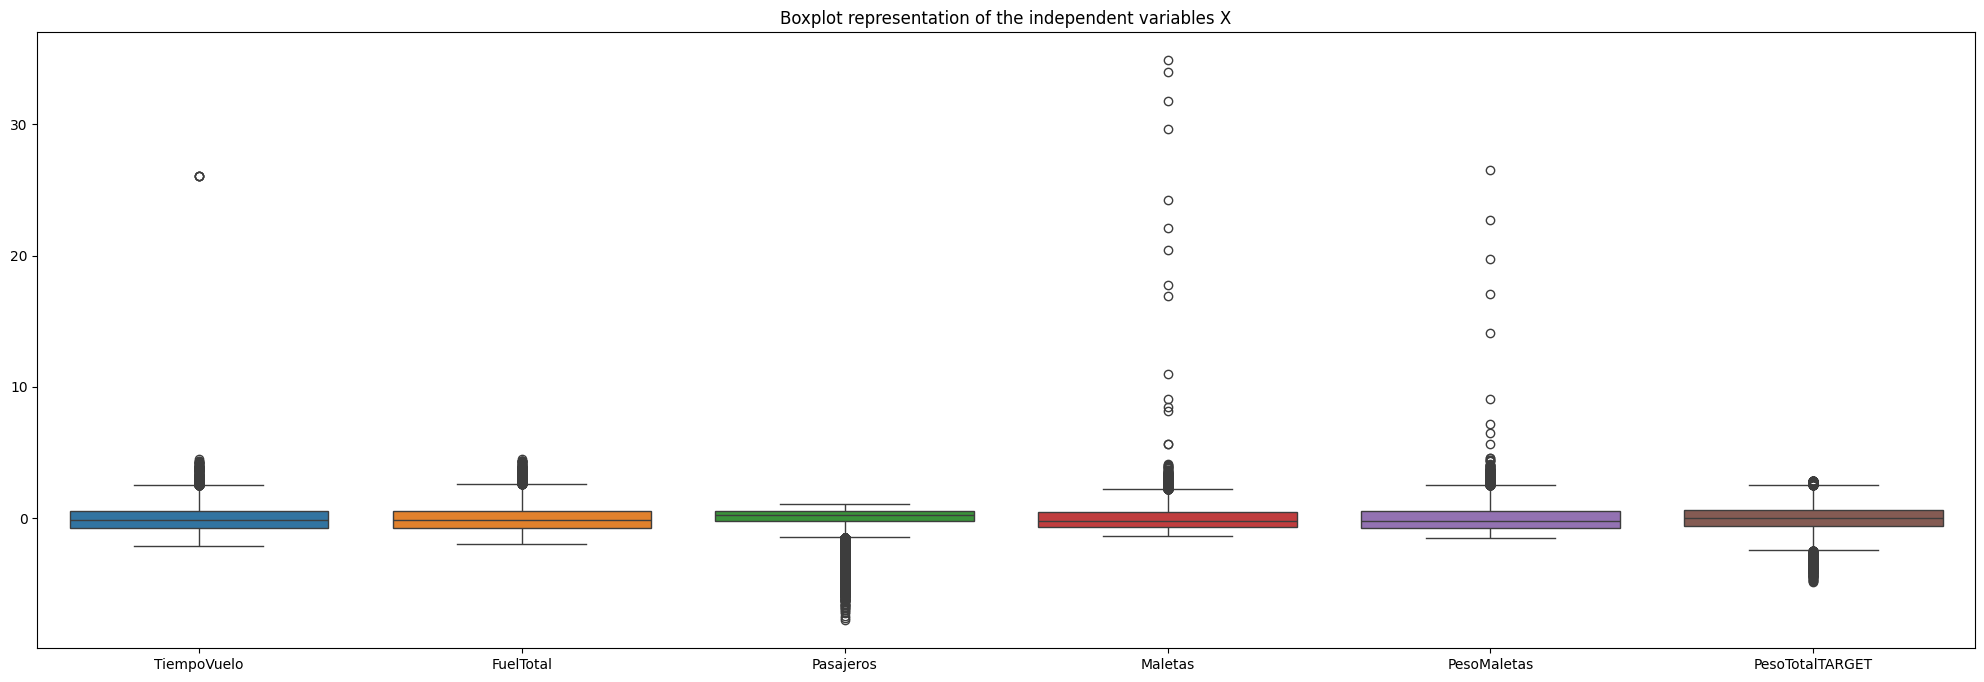

In [40]:
# Boxplots:
# I plot the distribution of the continuous predictor variables (normalized)

continuas = train.drop(['AeropuertoLlegada', 'AeropuertoSalida', 'DiaSalida', 'NumeroVuelo', 'Ruta'], axis=1)

continuas_normalizado = (continuas - continuas.mean()) / continuas.std()

plt.figure(figsize=(25,8))
sns.boxplot(data=continuas_normalizado)
plt.title('Boxplot representation of the independent variables X')
_ = plt.xlabel('')


In [41]:
# I decided to remove some of the records where the values for the variables 'TiempoVuelo', 'Maletas', and 'PesoMaletas' had a risk of being outliers.

# Save dimension
con_nulos=train.shape

# Positions of the outliers that I am going to remove:
    #print(np.where(train['TiempoVuelo'] > 800))
    #print(np.where(train['Maletas'] > 400))
    #print(np.where(train['PesoMaletas'] > 4000))
'''
train = train.drop(train[train['TiempoVuelo'] > 800].index |
                         train[train['Maletas'] > 400].index |
                         train[train['PesoMaletas'] > 4000].index)
'''
# Create a mask for outliers
outliers_mask = (train['TiempoVuelo'] > 800) | (train['Maletas'] > 400) | (train['PesoMaletas'] > 4000)

# Drop the outliers
train = train[~outliers_mask]

In [42]:
print('Train dimension before removing null values: ', con_nulos)
print('Train dimension after removing null values: ', train.shape)

Train dimension before removing null values:  (26800, 11)
Train dimension after removing null values:  (26782, 11)


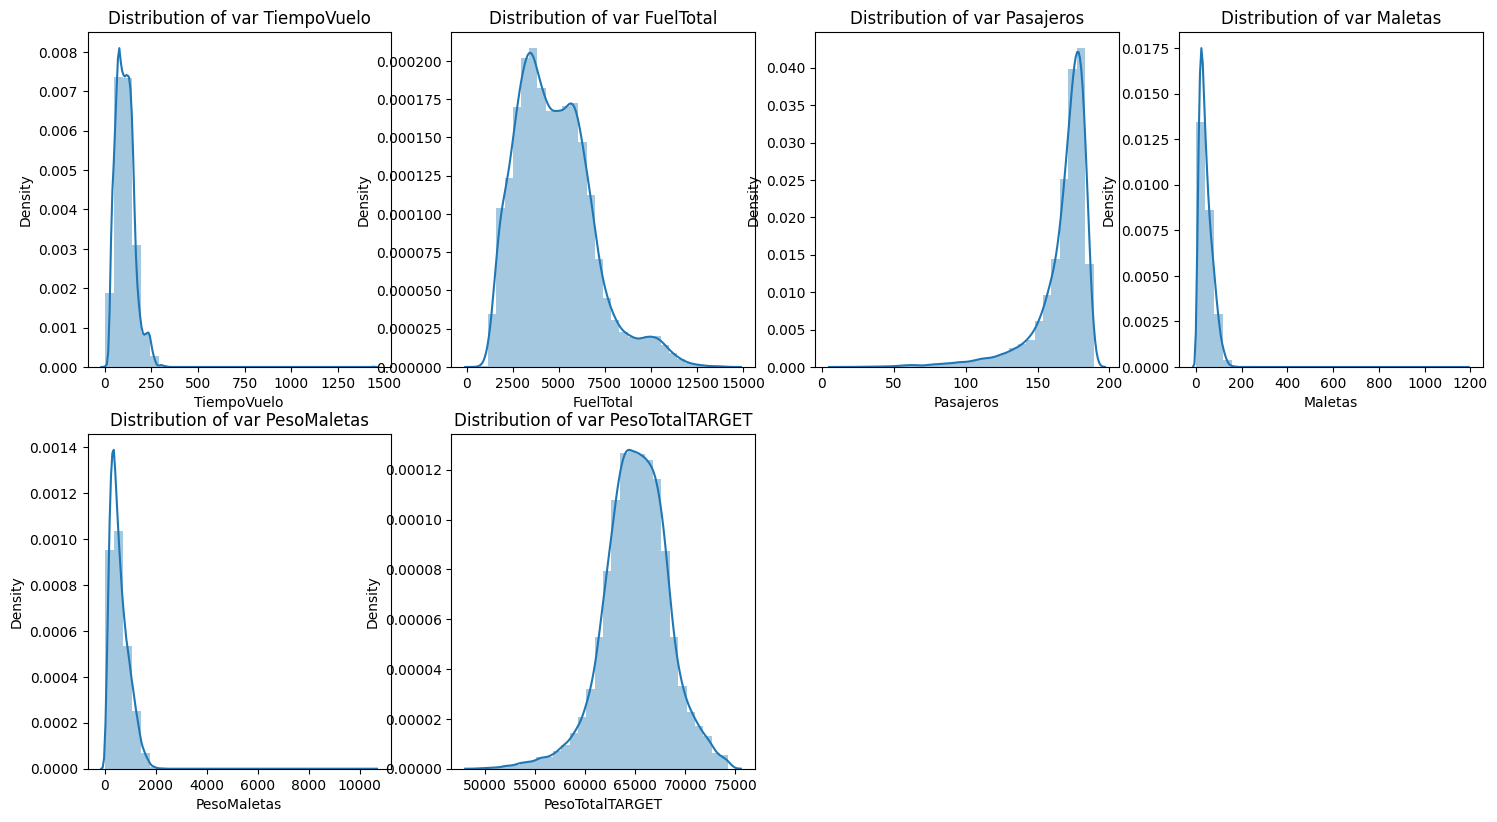

In [43]:
# Before removing the outliers
plt.figure(figsize=(18,20))
for i, column in enumerate(continuas.columns):
    plt.subplot(4, 4, i+1)
    sns.distplot(continuas[column], bins=30)
    plt.title('Distribution of var {}'.format(column))
plt.show()

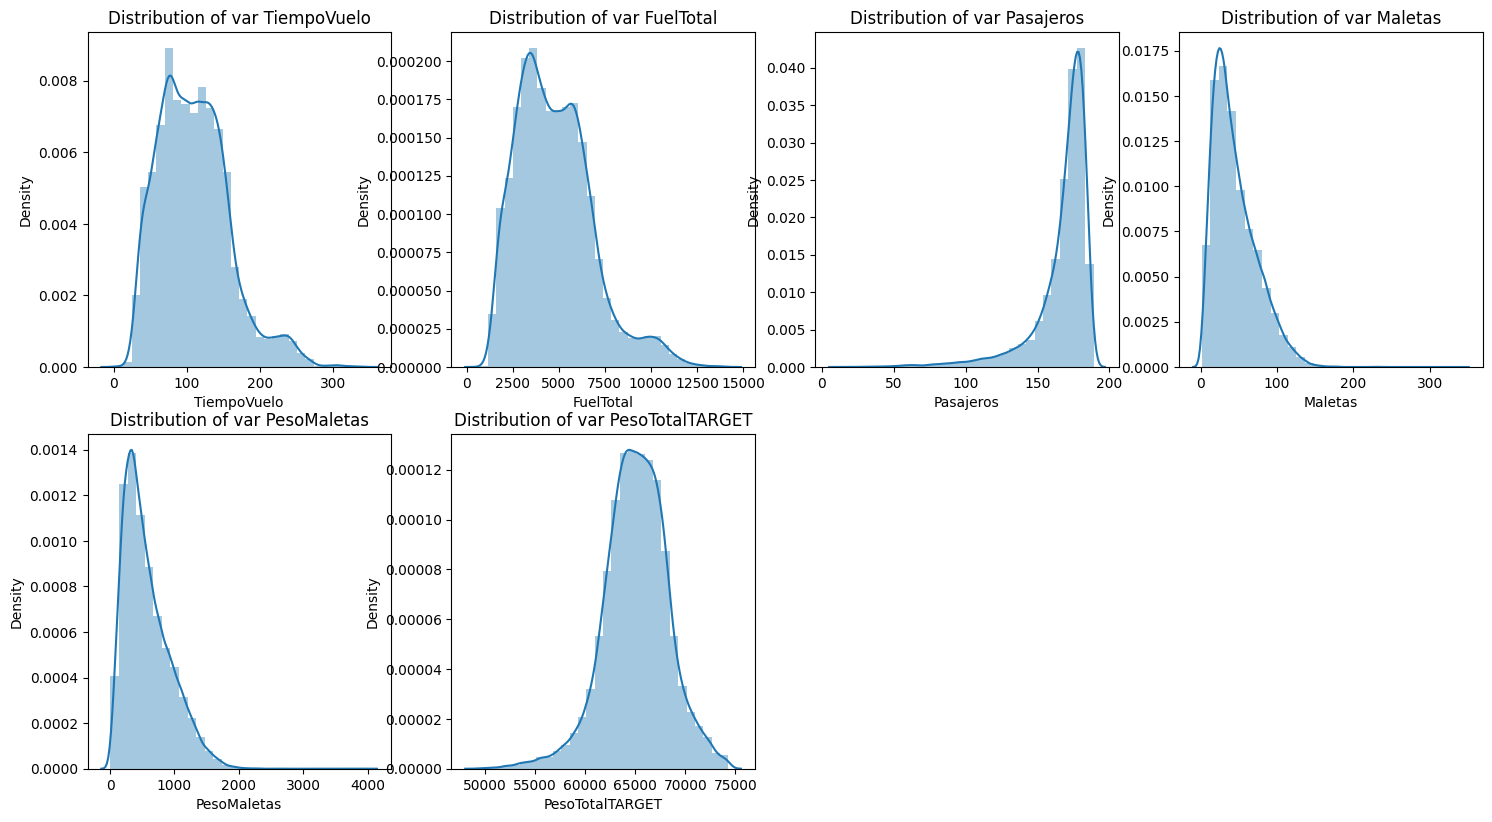

In [44]:
# Improvement after removing outliers
continuas = train.drop(['AeropuertoLlegada', 'AeropuertoSalida', 'DiaSalida', 'NumeroVuelo', 'Ruta'], axis=1)
plt.figure(figsize=(18,20))
for i, column in enumerate(continuas.columns):
    plt.subplot(4, 4, i+1)
    sns.distplot(continuas[column], bins=30)
    plt.title('Distribution of var {}'.format(column))
plt.show()


In [47]:
# standardize data
# Separate numerical and categorical features
num_cols = ['DiaSalida', 'TiempoVuelo', 'FuelTotal', 'Pasajeros', 'Maletas', 'PesoMaletas']
cat_cols = ['NumeroVuelo', 'AeropuertoSalida', 'AeropuertoLlegada', 'Ruta']

# Standardize numerical features
scaler = StandardScaler()
train[num_cols] = scaler.fit_transform(train[num_cols])
test[num_cols] = scaler.transform(test[num_cols])  # Use transform, not fit_transform

# Apply One-Hot Encoding to categorical columns
train = pd.get_dummies(train, columns=cat_cols, drop_first=True)
test = pd.get_dummies(test, columns=cat_cols, drop_first=True)


In [48]:
# I split df_train into predictor variables and the target variable

features = list(train.columns)
label = features.pop(-1)

x = train[features]
y = train[label]

X_train, X_test, y_train, y_test = train_test_split(x,y, test_size=0.15, random_state=0)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(22764, 6075)
(4018, 6075)
(22764,)
(4018,)


In [49]:
trainX = pd.DataFrame(X_train)
trainX[label] = y_train

testX = pd.DataFrame(X_test)
testX[label] = y_test

print(trainX.shape)
print(testX.shape)

(22764, 6076)
(4018, 6076)


In [50]:
# Correlations vs target
numeric_train = train.select_dtypes(include=['number'])
corr_matrix = numeric_train.corr(method='pearson')
# Correlations between the predictor variables and the target, then sorts them in descending order by absolute value:

correlaciones_target = corr_matrix.values[-1, :-1]
inverse_indices = abs(correlaciones_target[:]).argsort()[::-1]
dictionary = {}
for name, correlation in zip(X_train.columns[inverse_indices], list(correlaciones_target[inverse_indices])):
    dictionary[name] = correlation
pd.DataFrame.from_dict(dictionary, orient='index', columns=['Correlation with the target'])

,Correlation with the target
FuelTotal,0.822656
TiempoVuelo,0.786183
Pasajeros,0.706333
PesoMaletas,0.620787
Maletas,0.614079
DiaSalida,-0.024022


In [51]:
trainX.to_csv("train-V-1.csv",index = False)
testX.to_csv("test-V-1.csv", index = False)

In [52]:
# send data to S3. SageMaker will take training data from s3
sk_prefix = "sagemaker/mobile_price_classification/sklearncontainer"
trainpath = sess.upload_data(
    path="train-V-1.csv", bucket=bucket, key_prefix=sk_prefix
)

testpath = sess.upload_data(
    path="test-V-1.csv", bucket=bucket, key_prefix=sk_prefix
)
print(trainpath)
print(testpath)

s3://bucketsagemaker-ia/sagemaker/mobile_price_classification/sklearncontainer/train-V-1.csv
s3://bucketsagemaker-ia/sagemaker/mobile_price_classification/sklearncontainer/test-V-1.csv


In [53]:
%%writefile script.py

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score, roc_curve, auc
import sklearn
import joblib
import boto3
import pathlib
from io import StringIO 
import argparse
import joblib
import os
import numpy as np
import pandas as pd
    
def model_fn(model_dir):
    clf = joblib.load(os.path.join(model_dir, "model.joblib"))
    return clf
    
if __name__ == "__main__":

    print("[INFO] Extracting arguments")
    parser = argparse.ArgumentParser()

    # hyperparameters sent by the client are passed as command-line arguments to the script.
    parser.add_argument("--n_estimators", type=int, default=100)
    parser.add_argument("--random_state", type=int, default=0)

    # Data, model, and output directories
    parser.add_argument("--model-dir", type=str, default=os.environ.get("SM_MODEL_DIR"))
    parser.add_argument("--train", type=str, default=os.environ.get("SM_CHANNEL_TRAIN"))
    parser.add_argument("--test", type=str, default=os.environ.get("SM_CHANNEL_TEST"))
    parser.add_argument("--train-file", type=str, default="train-V-1.csv")
    parser.add_argument("--test-file", type=str, default="test-V-1.csv")

    args, _ = parser.parse_known_args()
    
    print("SKLearn Version: ", sklearn.__version__)
    print("Joblib Version: ", joblib.__version__)

    print("[INFO] Reading data")
    print()
    train = pd.read_csv(os.path.join(args.train, args.train_file))
    test = pd.read_csv(os.path.join(args.test, args.test_file))
    
    features = list(train.columns)
    label = features.pop(-1)
    
    print("Building training and testing datasets")
    print()
    X_train = train[features]
    X_test = test[features]
    y_train = train[label]
    y_test = test[label]

    print('Column order: ')
    print(features)
    print()
    
    print("Label column is: ",label)
    print()
    
    print("Data Shape: ")
    print()
    print("---- SHAPE OF TRAINING DATA (85%) ----")
    print(X_train.shape)
    print(y_train.shape)
    print()
    print("---- SHAPE OF TESTING DATA (15%) ----")
    print(X_test.shape)
    print(y_test.shape)
    print()
    
  
    print("Training RandomForest Model.....")
    print()
    model =  RandomForestClassifier(n_estimators=args.n_estimators, random_state=args.random_state, verbose = 3,n_jobs=-1)
    model.fit(X_train, y_train)
    print()
    

    model_path = os.path.join(args.model_dir, "model.joblib")
    joblib.dump(model,model_path)
    print("Model persisted at " + model_path)
    print()

    
    y_pred_test = model.predict(X_test)
    test_acc = accuracy_score(y_test,y_pred_test)
    test_rep = classification_report(y_test,y_pred_test)

    print()
    print("---- METRICS RESULTS FOR TESTING DATA ----")
    print()
    print("Total Rows are: ", X_test.shape[0])
    print('[TESTING] Model Accuracy is: ', test_acc)
    print('[TESTING] Testing Report: ')
    print(test_rep)

Overwriting script.py


In [54]:
from sagemaker.sklearn.estimator import SKLearn

FRAMEWORK_VERSION = "0.23-1"

sklearn_estimator = SKLearn(
    entry_point="script.py",
    role="arn:aws:iam::911167928480:role/service-role/AmazonSageMaker-ExecutionRole-20240921T130531",
    instance_count=1,
    instance_type="ml.m5.large",
    framework_version=FRAMEWORK_VERSION,
    base_job_name="RF-custom-sklearn",
    hyperparameters={
        "n_estimators": 100,
        "random_state": 0,
    },
    use_spot_instances = True,
    max_wait = 7200,
    max_run = 3600
)

In [55]:
# launch training job, with asynchronous call
sklearn_estimator.fit({"train": trainpath, "test": testpath}, wait=True)
# sklearn_estimator.fit({"train": datapath}, wait=True)

INFO:sagemaker:Creating training-job with name: RF-custom-sklearn-2024-09-21-11-28-43-248


2024-09-21 11:28:36 Starting - Starting the training job...
2024-09-21 11:28:51 Starting - Preparing the instances for training...
2024-09-21 11:29:14 Downloading - Downloading input data...
2024-09-21 11:29:54 Downloading - Downloading the training image...
2024-09-21 11:30:25 Training - Training image download completed. Training in progress.2024-09-21 11:30:29,705 sagemaker-containers INFO     Imported framework sagemaker_sklearn_container.training
2024-09-21 11:30:29,708 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2024-09-21 11:30:29,745 sagemaker_sklearn_container.training INFO     Invoking user training script.
2024-09-21 11:30:29,905 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2024-09-21 11:30:29,916 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2024-09-21 11:30:29,928 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2024-09-21 11:3